## Разработка стратегии взаимодействия с клиентами фитнес-центров 

**Цель работы** — провести анализ и подготовить план действий по удержанию клиентов.  

**Задачи:**
1) подготовить данные к анализу;
2) провести исследовательский анализ данных;
3) построить модель прогнозирования вероятности оттока (на уровне следующего месяца) для каждого клиента;
4) осуществить кластеризацию клиентов:
    - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    - проанализировать основные признаки, наиболее сильно влияющие на отток;
5) сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.

### Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats as st 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv(r"C:\Users\tsyko\Downloads\gym_churn.csv", sep=',')

In [3]:
df #посмотрим на датасет

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропусков нет, очень здорово!

In [5]:
#можно поменять тип данных столбца Month_to_end_contract на int, тк значения указаны в месяцах (то есть в целых числах)
df['Month_to_end_contract'] = df['Month_to_end_contract'].astype(int)
df.info() #проверим результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   int32  
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
df.duplicated().sum() #проверим данные на наличие дубликатов

0

Отлично! 
В нашем распоряжении данные без пропусков, дубликатов и с корректными типами данных! Можем идти дальше

## Проведём исследовательский анализ данных

In [7]:
df.describe().round(3)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.00,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000,4000.000
mean,0.51,0.845,0.487,0.308,0.904,4.681,0.412,29.184,146.944,4.323,3.725,1.879,1.767,0.265
std,0.50,0.362,0.500,0.462,0.295,4.550,0.492,3.258,96.356,4.191,3.749,0.972,1.053,0.442
min,0.00,0.000,0.000,0.000,0.000,1.000,0.000,18.000,0.148,1.000,0.000,0.000,0.000,0.000
25%,0.00,1.000,0.000,0.000,1.000,1.000,0.000,27.000,68.869,1.000,1.000,1.181,0.963,0.000
50%,1.00,1.000,0.000,0.000,1.000,1.000,0.000,29.000,136.220,1.000,3.000,1.833,1.720,0.000
75%,1.00,1.000,1.000,1.000,1.000,6.000,1.000,31.000,210.950,6.000,5.000,2.536,2.510,1.000
max,1.00,1.000,1.000,1.000,1.000,12.000,1.000,41.000,552.591,12.000,31.000,6.024,6.147,1.000


Посмотрим на средние значения и стандартные отклонения признаков:

- пол равномерно распределён, то есть количество женщин примерно равно количеству мужчин
- у большинства посетителей фитнес-центра (84%) дом или работа находятся в этом же районе
- почти половина посетителей являются сотрудниками компании-партнёра клуба
- около 31% посетителей пришли в фитнес-центр благодаря акции "приведи друга"
- 90% посетителей оставили свой контактный телефон
- судя по среднему значению и стандартному отклонению длительности текущего действующего абонемента, преобладают значения 1 и 6; вероятнее всего наиболее популярны абонементы на 1 месяц, также много абонементов на 6 месяцев и в меньшестве годовые абонементы
- 41% посетителей посещают групповые занятия
- клиентам фитнес-центра от 18 до 41 года, в среднем 29 лет и, судя по небольшому стандартному отклонению, разброс от этого значения небольшой, то есть большинство клиентов в возрасте около 29 лет
- насчёт суммарной выручки от других услуг фитнес-центра, не очень ясно, в чём она выражается: если в рублях, то почему такие маленькие значения, например, минимальное значение - 0.15, а максимальное 553, возможно при парсинге данных возникли ошибки; но в целом можно сказать, что разброс достаточно большой
- в столбце с количеством месяцев до окончания абонемента довольно большой разброс, большое стандартное отклонение - 4.2, среднее количество месяцев - 4, при этом медианное значение 1 месяц; вероятно это связано с тем, что у большинства клиентов длительность текущего абонемента составляет 1 месяц
- в основном, клиенты обратились в фитнес-центр 3-4 месяца назад (судя по медиане и среднему), но стандартное отклонение большое, поэтому есть как и те, кто занимается уже полгода, так и много новичков
- в основном клиенты посещают фитнес-центр 1-3 (чаще 2) раза в неделю, как по данным за всё всремя с начала действия абонемента, так и за прошлый месяц
- около четверти клиентов (26.5%) покинули фитнес-центр в текущем месяце

Теперь сравним признаки для тех, кто ушёл (1) и кто остался (0) в фитнес-центре

In [8]:
df.assign(Churn=df['Churn'].replace({0: 'остались', 1: 'ушли'})).groupby('Churn').agg('mean').T.round(3)

Churn,остались,ушли
gender,0.510,0.511
Near_Location,0.873,0.768
Partner,0.534,0.355
Promo_friends,0.354,0.184
Phone,0.904,0.903
Contract_period,5.747,1.729
Group_visits,0.464,0.269
Age,29.977,26.990
Avg_additional_charges_total,158.446,115.083
Month_to_end_contract,5.283,1.663


Итак, можно заметить, что клиенты, покинувшие фитнес-центр, реже являлись сотрудниками компании-партнёра клуба или были приглашены по акции "приведи друга", чаще имели абонемент длительностью 1 месяц, немного реже посещали групповые занятия и тратили меньше средств в фитнес-центре (доп. услуги), пришли недавно (около 1 месяца) и посещали зал реже (1 раз в неделю)

Построим гистограммы для непрерывных переменных

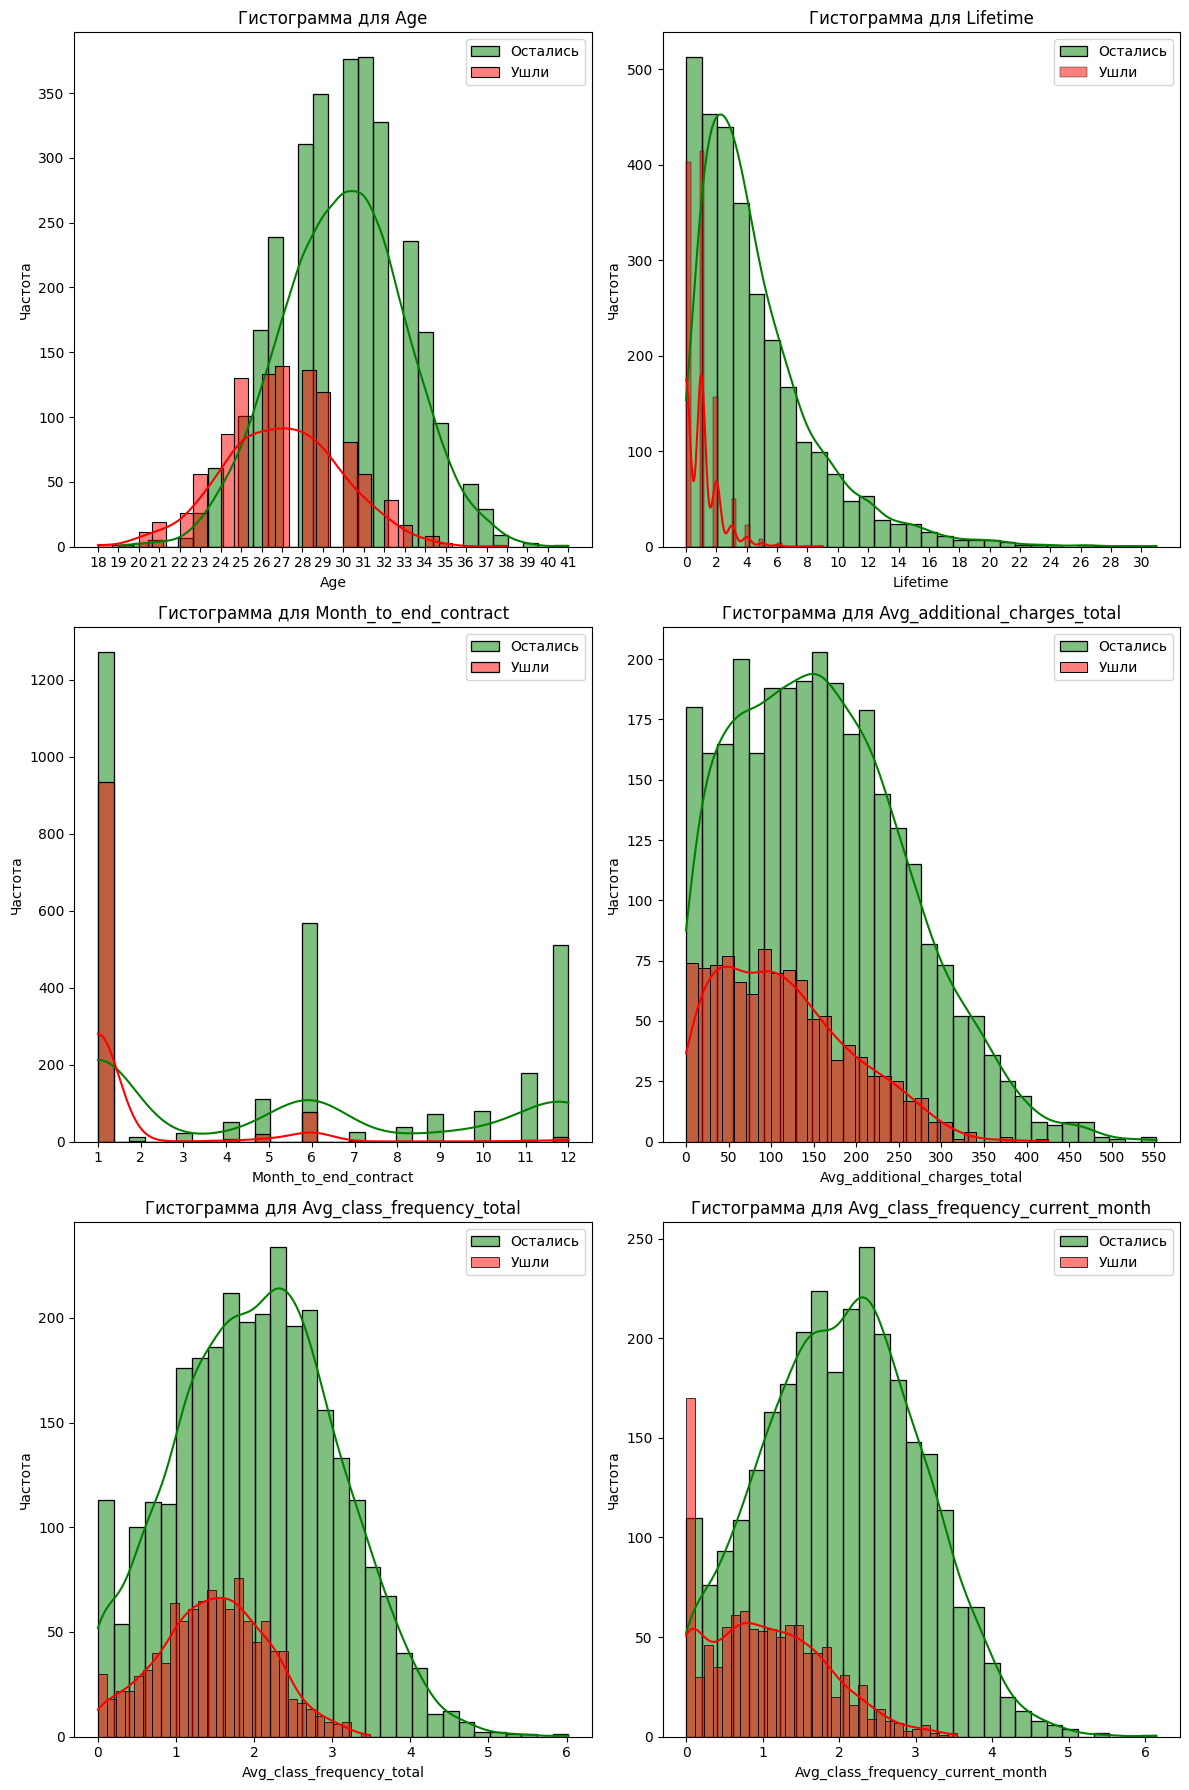

In [9]:
num_cols = ['Age', 'Lifetime', 'Month_to_end_contract', 
            'Avg_additional_charges_total', 'Avg_class_frequency_total', 
            'Avg_class_frequency_current_month']

df_0 = df[df['Churn'] == 0]
df_1 = df[df['Churn'] == 1]

n_cols = len(num_cols)
n_rows = (n_cols + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 6 * n_rows))

for i, col in enumerate(num_cols):
    ax = axes[i // 2, i % 2]
    sns.histplot(df_0[col], ax=ax, bins=30, alpha=0.5, label='Остались', color='green', kde=True)
    sns.histplot(df_1[col], ax=ax, bins=30, alpha=0.5, label='Ушли', color='red', kde=True)
    ax.set_title(f'Гистограмма для {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Частота')

    if col == 'Lifetime':
        ax.set_xticks(range(0, int(df[col].max()) + 1, 2))
    elif col == 'Avg_additional_charges_total':
        ax.set_xticks(range(0, int(df[col].max()) + 1, 50))
    else:
        ax.set_xticks(range(int(df[col].min()), int(df[col].max()) + 1))
    ax.legend()

plt.tight_layout()
plt.show()

Теперь наглядно видно то, о чём говорили выше: клиенты, покинувшие фитнес-центр, немного моложе, пришли недавно, тратят меньше средств на доп. услуги и реже ходят на тренировки 

Также можно отметить, что выбросов (аномальных значений) не наблюдается. Для Lifetime нормально высокое значение около 0, тк, вероятно, часть клиентов только в этом месяце впервые обратились в фитнес-центр; часть клиентов не тратит деньги на дополнительные услуги ('Avg_additional_charges_total'); часть клиентов могут ходить на тренировки раз в несколько недель/месяц и поэтому средние значения за неделю меньше нуля ('Avg_class_frequency_total', 'Avg_class_frequency_current_month')

Теперь посмотрим на категориальные признаки

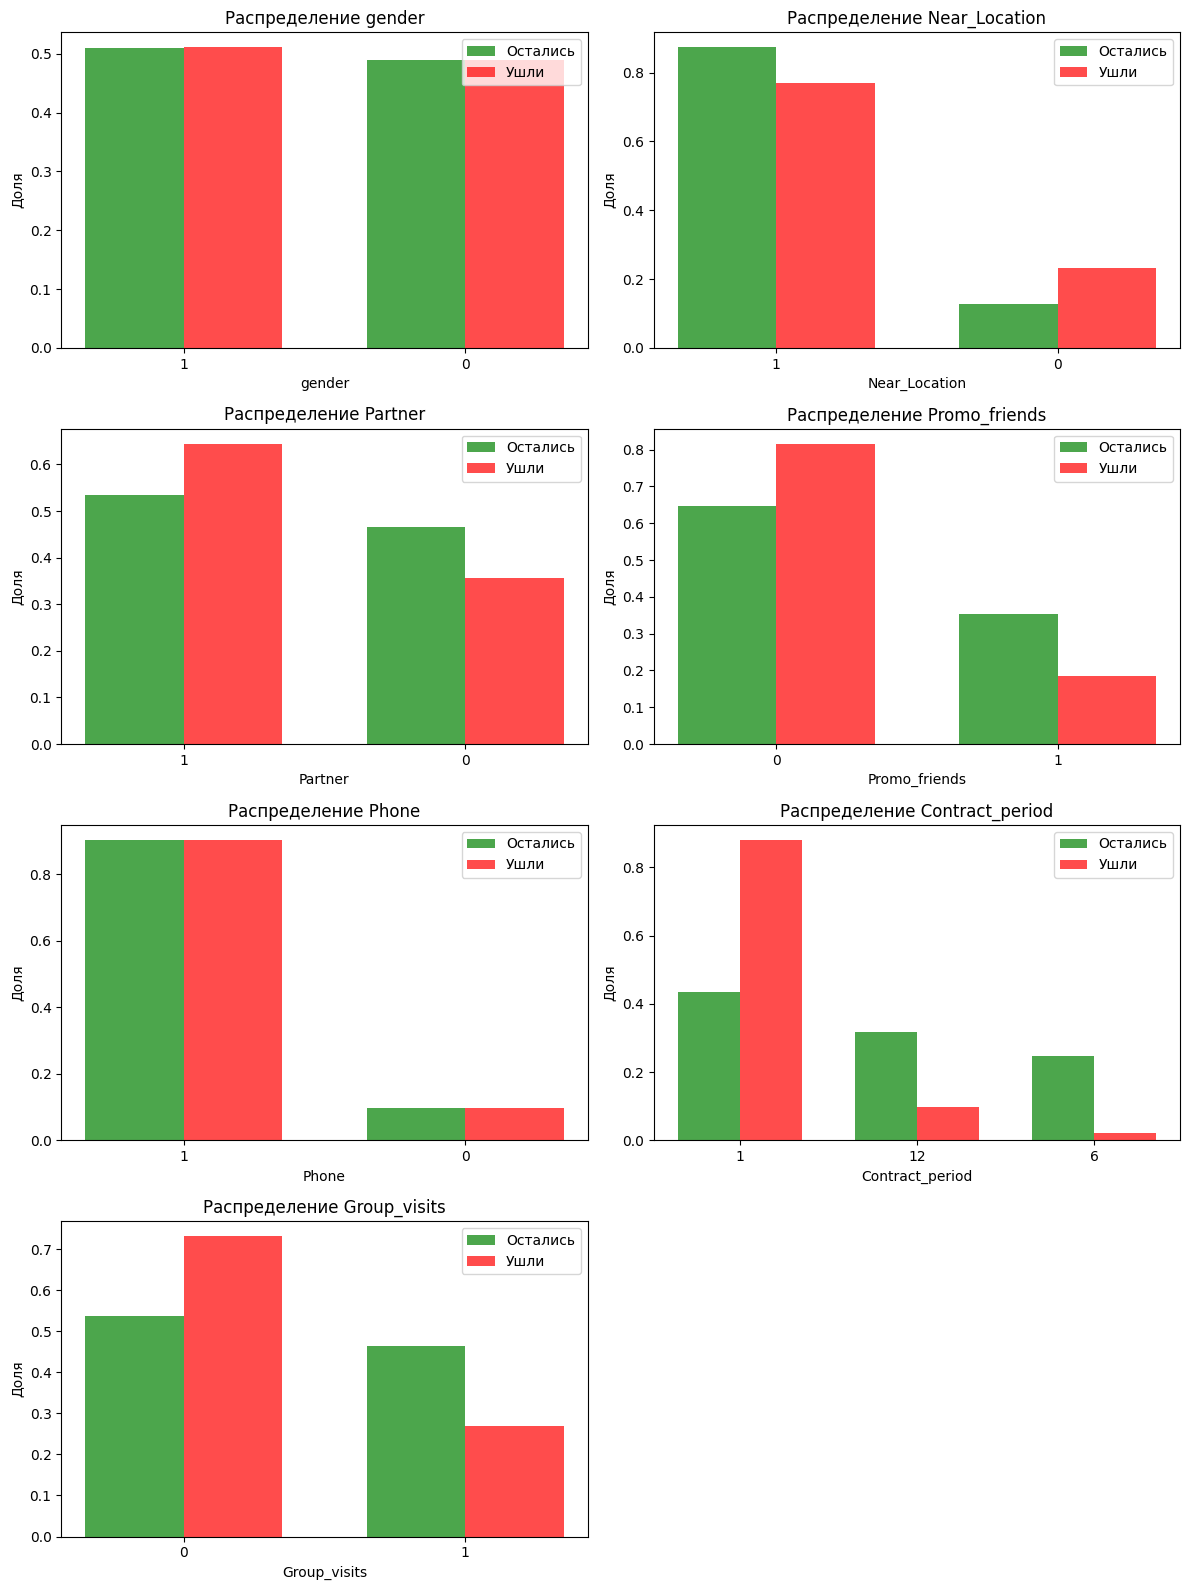

In [10]:
cat_cols = [col for col in df.columns if col not in num_cols and col != 'Churn']

fig, axes = plt.subplots(nrows=(len(cat_cols)+1)//2, ncols=2, figsize=(12, 4*((len(cat_cols)+1)//2)))

axes = axes.flatten() if len(cat_cols) > 1 else [axes]

for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    churn_0_counts = df[df['Churn'] == 0][col].value_counts(normalize=True)
    churn_1_counts = df[df['Churn'] == 1][col].value_counts(normalize=True)
    
    x = np.arange(len(churn_0_counts))
    width = 0.35
    
    ax.bar(x - width/2, churn_0_counts.values, width, label='Остались', color='green', alpha=0.7)
    ax.bar(x + width/2, churn_1_counts.values, width, label='Ушли', color='red', alpha=0.7)
    
    ax.set_title(f'Распределение {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Доля')
    ax.set_xticks(x)
    ax.set_xticklabels(churn_0_counts.index)
    ax.legend()

# удаление лишних столбчатых диаграмм, тк число столбцов нечетное
if len(cat_cols) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Столбчатые диаграммы также подтверждают вышеописанные наблюдения. Наиболее явные различия: длительность абонемента, посещение групповых занятий

Посмотрим на матрицу корреляций

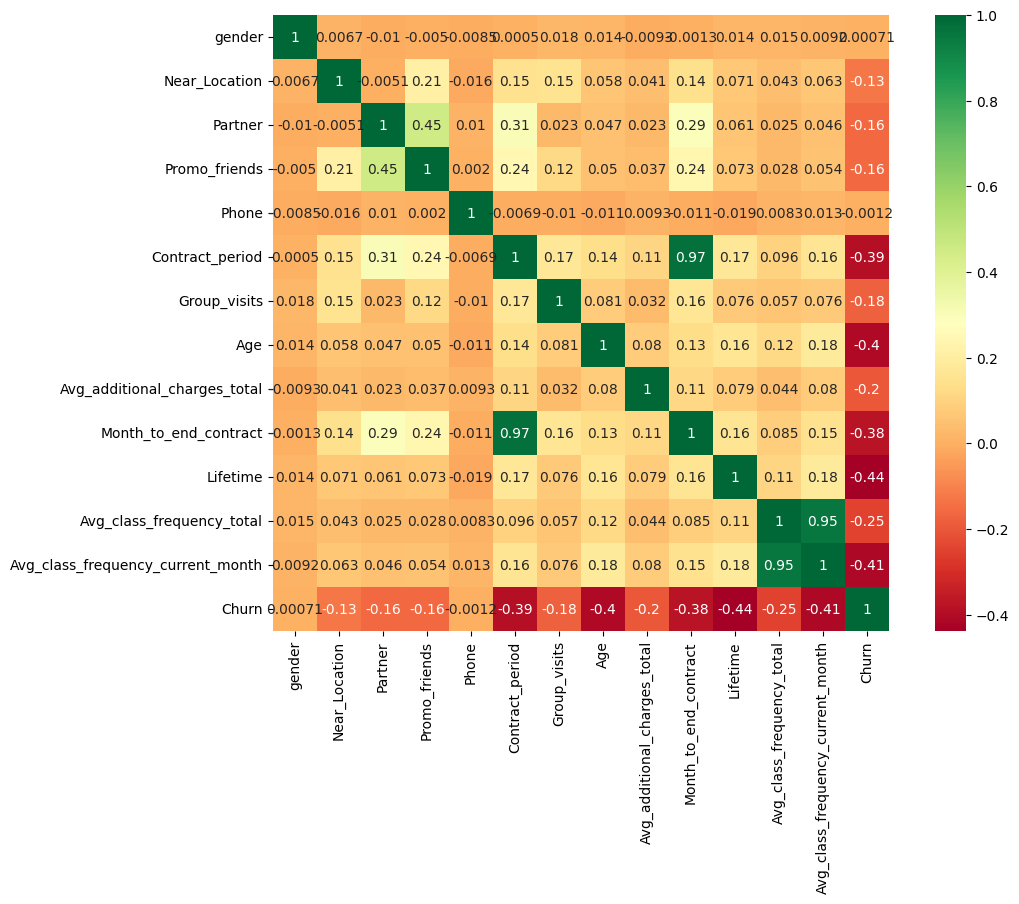

In [11]:
cm = df.corr() 
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(cm, annot=True, square=True, cmap='RdYlGn') 
ax.set_ylim(
    14, 0
)  
plt.show()

Можем заметить, что на отток клиентов влияют: длительность текущего действующего абонемента, возраст, срок до окончания текущего действующего абонемента, время с момента первого обращения в фитнес-центр и средняя частота посещений в неделю за предыдущий месяц. Остальные признаки либо влияют в меньшей степени, либо не влияют вовсе.

In [12]:
df = df.drop(['Month_to_end_contract'], axis=1) # удалим один из сильно коррелирующих между собой признаков
df = df.drop(['Avg_class_frequency_total'], axis=1) # также удалим один признак из второй пары сильно коррелирующих признаков;
                                                    #оставим посещаемость за месяц, тк она больше влияет на отток

**Выдвинем предварительную гипотезу:**

На отток клиентов фитнес-центра влияют длительность текущего действующего абонемента, возраст, время с момента первого обращения в фитнес-центр и средняя частота посещений в неделю за предыдущий месяц. А именно: наиболее высокая вероятность оттока наблюдается для клиентов молодого возраста, которые недавно купили абонемент на месяц и посещают фитнес-центр 1 раз в неделю

## Построим модель прогнозирования оттока клиентов

In [13]:
X = df.drop(['Churn'], axis=1) 
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

scaler = StandardScaler()  

X_train_st = scaler.fit_transform(X_train)

print(X_train_st[:5])

X_test_st = scaler.transform(X_test)

[[ 0.97408566  0.4267557  -0.96801137 -0.66294508  0.33794397 -0.80548687
  -0.8325393  -0.98368917 -1.20839807 -0.72918618 -1.41605129]
 [-1.02660376  0.4267557  -0.96801137 -0.66294508  0.33794397  0.290041
  -0.8325393   0.55874779 -0.01946282  0.35573572 -0.05430809]
 [-1.02660376  0.4267557  -0.96801137 -0.66294508 -2.95907039  1.60467445
  -0.8325393   0.55874779  0.12266575 -0.72918618 -0.5645482 ]
 [ 0.97408566  0.4267557   1.03304572  1.50842058  0.33794397  0.290041
   1.20114449  1.17572257  1.33280571  2.25434906 -0.37358867]
 [-1.02660376  0.4267557   1.03304572  1.50842058  0.33794397 -0.80548687
   1.20114449  1.48420996 -1.10522792  0.08450525  1.47318586]]


In [14]:
# будем тестировать два алгоритма: логистическую регрессию
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_st, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [15]:
# и случайный лес
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_st, y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred_lr = log_reg.predict(X_test_st)
y_pred_rf = rf.predict(X_test_st)

In [17]:
# логистическая регрессия
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)

# случайный лес
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)

print("Метрики для Логистической регрессии:")
print(f"Accuracy: {lr_accuracy:.3f}")
print(f"Precision: {lr_precision:.3f}")
print(f"Recall: {lr_recall:.3f}")
print("\nМетрики для Случайного леса:")
print(f"Accuracy: {rf_accuracy:.3f}")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall: {rf_recall:.3f}")

Метрики для Логистической регрессии:
Accuracy: 0.905
Precision: 0.825
Recall: 0.792

Метрики для Случайного леса:
Accuracy: 0.887
Precision: 0.818
Recall: 0.713


**Логистическая регрессия оказалась лучше**

Нам страшнее упустить клиента, который собирался уйти, чем спрогнозировать уход постоянному клиенту, поэтому в первую очередь смотрим на метрику recall; но можно заметить, что логистическая регрессия обошла случайный лес по всем метрикам

## Произведем кластеризацию клиентов

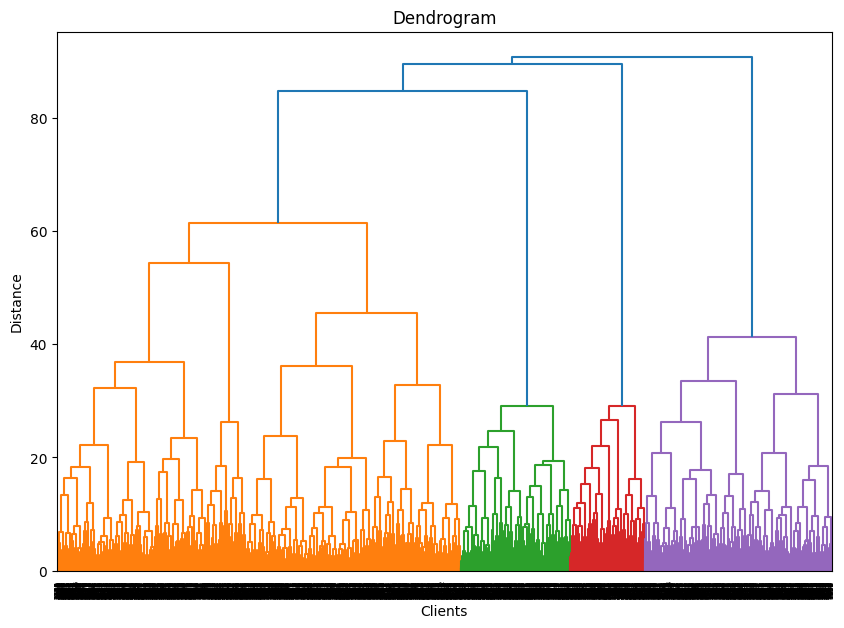

In [18]:
X = df.drop('Churn', axis=1)

# стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# построим матрицу расстояний и нарисуем дендрограмму
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Clients')
plt.ylabel('Distance')
plt.show()


Судя по дендрограмме можно выделить 4-5 кластеров

In [19]:
# обучим модель кластеризации на основании алгоритма K-Means
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Посмотрим на средние значения признаков для кластеров 
cluster_means = df.groupby('Cluster').mean().round(3)
print("Средние значения признаков для кластеров:")
print(cluster_means)

Средние значения признаков для кластеров:
         gender  Near_Location  Partner  Promo_friends  Phone  \
Cluster                                                         
0         0.498          0.000    0.488          0.079    1.0   
1         0.506          0.994    0.840          0.625    1.0   
2         0.528          1.000    0.000          0.055    1.0   
3         0.523          0.863    0.472          0.306    0.0   
4         0.484          1.000    0.935          0.541    1.0   

         Contract_period  Group_visits     Age  Avg_additional_charges_total  \
Cluster                                                                        
0                  3.016         0.234  28.698                       137.521   
1                  9.886         0.630  30.333                       174.669   
2                  2.737         0.406  29.032                       142.723   
3                  4.777         0.427  29.298                       144.208   
4                  2.7

В **нулевой кластер** попали клиенты с самым высоким оттоком - *клиенты из других районов, половина из которых являются сотрудниками компании-партнёра клуба*, занимаются в фитнес-центре около 3-х месяцев, чуть меньше четверти посещают групповые занятия, ходят на тренировки 1-2 раза в неделю.

В **первый кластер** попали клиенты с самым низким оттоком - клиенты, которые живут или работают в одном с фитнес-центром районе, в большинстве являются сотрудниками компании-партнёра или приглашены по акции "приведи друга", *приобрели абонементы, в основном, на 6 или 12 месяцев*; больше половины таких клиентов ходят на групповые занятия, тратят больше остальных клиентов на дополнительные услуги, посещают центр дольше всех - 5.5 месяцев и *ходят на тренировки чаще остальных* (2+ раза в неделю).

Во **второй кластер** попали клиенты со средним оттоком - *клиенты, которые живут или работают в одном с фитнес-центром районе, но при этом не являются сотрудниками компании-партнёра и не приглашены по акции "приведи друга", приобрели абонементы на не очень большой срок*, чуть меньше половины клиентов ходят на групповые тренировки, занимаются в фитнес-центре около 3-х месяцев, посещают занятия 1-2 раза в неделю.

В **третий кластер** попали клиенты с низким оттоком - клиенты, которые живут или работают в одном с фитнес-центром районе, половина из которых являются сотрудниками компании-партнёра, а треть приглашены по акции "приведи друга", интересно, что они *не оставили контактный телефон*, в основном, приобрели абонементы на 6 месяцев, посещают групповые тренировки, занимаются в фитнес-центре около 4-х месяцев, посещают занятия 1-2 раза в неделю.

В **четвёртый кластер** попали клиенты с высоким оттоком - клиенты, которые *живут или работают в одном с фитнес-центром районе, в большинстве являются сотрудниками компании-партнёра или (54%) приглашены по акции "приведи друга"*; только четверть клиентов посещают групповые тренировки, тратят меньше средств на дополнительные услуги, по сравнению с другими кластерами; приобрели *абонементы на небольшой срок (в основном, 1 месяц) и ходят на тренировки реже остальных*.

Остальные признаки (пол, возраст) не сильно различаются между кластерами.

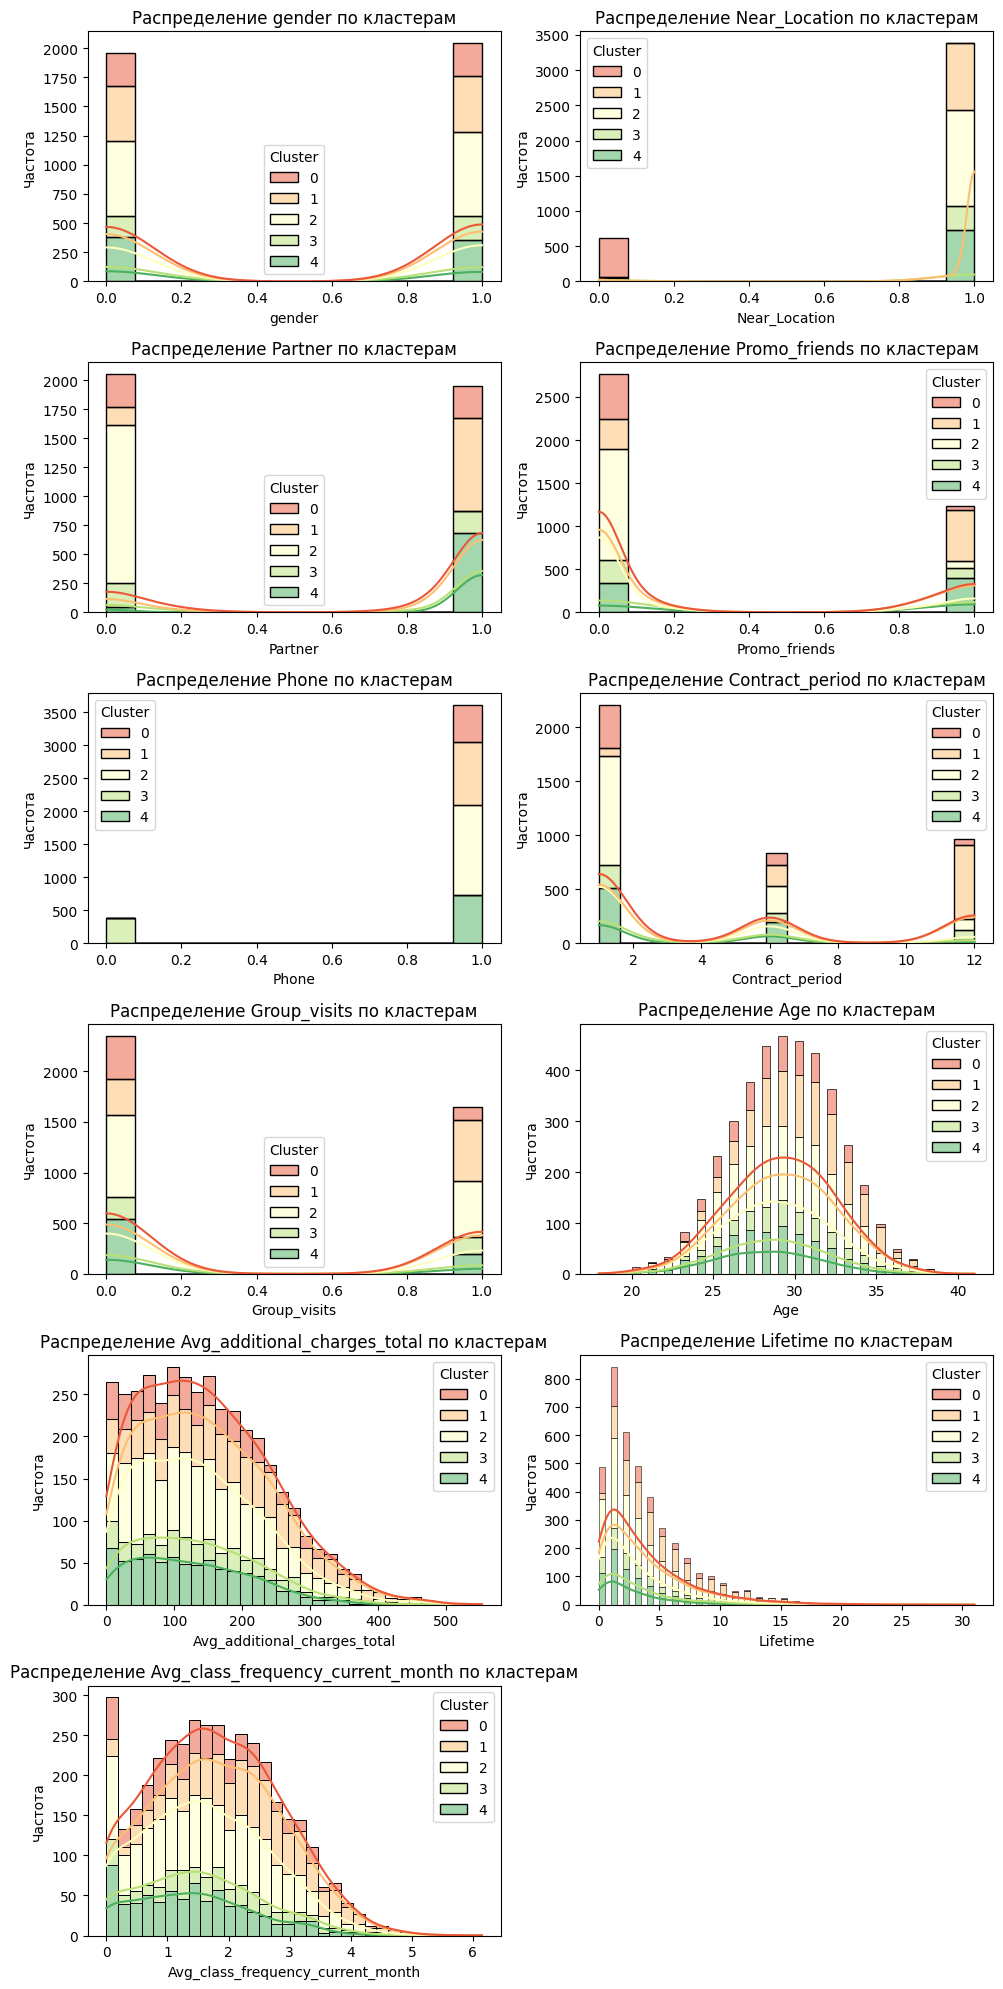

In [20]:
palette = sns.color_palette('RdYlGn', 5)

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 20))
axes = axes.flatten()

for i, column in enumerate(X.columns):
    sns.histplot(data=df, x=column, hue='Cluster', multiple='stack', kde=True, palette=palette, ax=axes[i])
    axes[i].set_title(f'Распределение {column} по кластерам')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Частота')

if len(X.columns) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Наиболее ярко выделяется первый кластер (1), остальные довольно похожи между собой

In [28]:
# ещё раз рассмотрим кластеры на предмет оттока
churn_rates = df.groupby('Cluster')['Churn'].mean()  
for cluster in churn_rates.index:
    rate = churn_rates[cluster]
    print(f'Кластер {cluster}: Доля оттока {rate:.3f}')

Кластер 0: Доля оттока 0.402
Кластер 1: Доля оттока 0.007
Кластер 2: Доля оттока 0.332
Кластер 3: Доля оттока 0.267
Кластер 4: Доля оттока 0.373


Отличительные черты каждого кластера и их анализ:

**Кластер 0:** клиенты из других районов - наибольший отток, возможно, неудобно добираться, не хочется тратить время на дорогу (открыть дополнительный зал там, где компании партнёры)

**Кластер 1:** наиболее лояльные клиенты, живут/работают в одном с фитнес-центром районе и являются сотрудниками компании-партнёра или приглашены по акции "приведи друга", активно занимаются, приобрели абонементы на длительный срок - удобно посещать фитнес-центр + выгодное предложение

**Кластер 2:** клиенты живут/работают в одном с фитнес-центром районе, приобрели абонемент на небольшой срок - удобное расположение центра

**Кластер 3:** клиенты не оставили контактный телефон - возможно, из-за этого пропускают акции/выгодные предложения

**Кластер 4:** клиенты живут/работают в одном с фитнес-центром районе и являются сотрудниками компании-партнёра или приглашены по акции "приведи друга", НО неохотно занимаются - удобное расположение, выгодное предложение, но низкая заинтересованность (предложить групповые тренировки, дополнительные услуги)

## Выводы:

Признаки, вероятно, влияющие на отток клиентов:
- длительность текущего действующего абонемента,
- возраст,
- время с момента первого обращения в фитнес-центр,
- средняя частота посещений в неделю за предыдущий месяц
  
*Наиболее высокая вероятность оттока наблюдается для клиентов молодого возраста, которые недавно купили абонемент на месяц и посещают фитнес-центр 1 раз в неделю.*

### **Кластеризация клиентов:**

В **нулевой кластер** попали клиенты с самым высоким оттоком - *клиенты из других районов, половина из которых являются сотрудниками компании-партнёра клуба*, занимаются в фитнес-центре около 3-х месяцев, чуть меньше четверти посещают групповые занятия, ходят на тренировки 1-2 раза в неделю.

В **первый кластер** попали клиенты с самым низким оттоком - клиенты, которые живут или работают в одном с фитнес-центром районе, в большинстве являются сотрудниками компании-партнёра или приглашены по акции "приведи друга", *приобрели абонементы, в основном, на 6 или 12 месяцев*; больше половины таких клиентов ходят на групповые занятия, тратят больше остальных клиентов на дополнительные услуги, посещают центр дольше всех - 5.5 месяцев и *ходят на тренировки чаще остальных* (2+ раза в неделю).

Во **второй кластер** попали клиенты со средним оттоком - *клиенты, которые живут или работают в одном с фитнес-центром районе, но при этом не являются сотрудниками компании-партнёра и не приглашены по акции "приведи друга", приобрели абонементы на не очень большой срок*, чуть меньше половины клиентов ходят на групповые тренировки, занимаются в фитнес-центре около 3-х месяцев, посещают занятия 1-2 раза в неделю.

В **третий кластер** попали клиенты с низким оттоком - клиенты, которые живут или работают в одном с фитнес-центром районе, половина из которых являются сотрудниками компании-партнёра, а треть приглашены по акции "приведи друга", интересно, что они *не оставили контактный телефон*, в основном, приобрели абонементы на 6 месяцев, посещают групповые тренировки, занимаются в фитнес-центре около 4-х месяцев, посещают занятия 1-2 раза в неделю.

В **четвёртый кластер** попали клиенты с высоким оттоком - клиенты, которые *живут или работают в одном с фитнес-центром районе, в большинстве являются сотрудниками компании-партнёра или (54%) приглашены по акции "приведи друга"*; только четверть клиентов посещают групповые тренировки, тратят меньше средств на дополнительные услуги, по сравнению с другими кластерами; приобрели *абонементы на небольшой срок (в основном, 1 месяц) и ходят на тренировки реже остальных*.

Остальные признаки (пол, возраст) не сильно различаются между кластерами.

### Рекомендации по удержанию клиентов из каждого кластера на основе его отличительной черты:

**Кластер 0:** клиенты из других районов - наибольший отток, возможно, неудобно добираться, не хочется тратить время на дорогу. ***Возможное решение:*** открыть дополнительный зал в районе, в котором находятся компании-партнёры.

**Кластер 1:** наиболее лояльные клиенты, живут/работают в одном с фитнес-центром районе и являются сотрудниками компании-партнёра или приглашены по акции "приведи друга", активно занимаются, приобрели абонементы на длительный срок - удобно посещать фитнес-центр + выгодное предложение. ***Возможное решение:*** создание программы лояльности (например, массаж в подарок за активное посещение групповых/персональных тренировок).

**Кластер 2:** клиенты живут/работают в одном с фитнес-центром районе, приобрели абонемент на небольшой срок - удобное расположение центра. ***Возможное решение:*** создание программы лояльности, предоставление персональных услуг (составление индивидуального плана тренировок, плана питания, анализ тела и тд).

**Кластер 3:** клиенты не оставили контактный телефон - возможно, из-за этого пропускают акции/выгодные предложения. ***Возможное решение:*** акционное предложение для тех, кто оставит контактный телефон (скидка на массаж/ персональную тренировку), и рассылка с предложениями фитнес-центра.

**Кластер 4:** клиенты живут/работают в одном с фитнес-центром районе и являются сотрудниками компании-партнёра или приглашены по акции "приведи друга", НО неохотно занимаются - удобное расположение, выгодное предложение, но низкая заинтересованность. ***Возможное решение:*** рассылка с приглашением на групповые тренировки и дополнительные услуги.


**Основная рекомендация: создание программы лояльности для клиентов**

Дополнительная рекомендация: данные хорошего качества (без пропусков, аномальных значений), но не очень понятно, в чём измеряется выручка, почему такие маленькие значение, поэтому необходимо проверить данные о выручке от других услуг фитнес-центра.